In [1]:
import os
import math
import json
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Configuration and Constants
Here we define basic plotting settings for visualization consistency and set up the RDW API endpoint used to retrieve open car registration data.

In [2]:
# Basic plotting config
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

# rdw api
RDW_ENDPOINT = "https://opendata.rdw.nl/resource/m9d7-ebf2.json"

### Symmetric MAPE Metric
We define a **Symmetric Mean Absolute Percentage Error (SMAPE)** function: a robust metric that evaluates prediction accuracy while handling zeros more gracefully than standard MAPE.


In [3]:
# --- Metrics ---
def smape(y_true, y_pred):
    """
    Symmetric MAPE in [0, 2]; lower is better.
    Handles zeros more gracefully than MAPE.
    """
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom[denom == 0] = 1.0
    return float(np.mean(2.0 * np.abs(y_pred - y_true) / denom))

### Winsorization Helper
This helper function **clips extreme values** (outliers) of a numerical column within each group (e.g., per brand and model).


Winsorization stabilizes averages and prevents outliers from distorting trend estimates.

In [4]:
# --- Winsorization helper ---
def winsorize_by_group(df, col, gcols, lo=0.01, hi=0.99):
    """
    Clip 'col' to the [lo, hi] quantiles per group (gcols).
    Avoids a few extreme prices from distorting averages.
    """
    def _w(g):
        if g[col].notna().sum() < 5:
            return g
        ql, qh = g[col].quantile([lo, hi])
        return g.assign(**{col: g[col].clip(ql, qh)})
    return df.groupby(gcols, group_keys=False).apply(_w)

### Fetching RDW Data
This function **queries the RDW Open Data API** for all cars of a given brand and model.  
It supports optional authentication through an app token and returns the results as a pandas DataFrame.


In [5]:
def fetch_rdw(merk: str, handelsbenaming: str, app_token: Optional[str]=None, limit:int=50000) -> pd.DataFrame:
    headers = {"X-App-Token": app_token} if app_token else {}
    params = {"merk": merk, "handelsbenaming": handelsbenaming, "$limit": limit}
    resp = requests.get(RDW_ENDPOINT, params=params, headers=headers, timeout=30)
    resp.raise_for_status()
    return pd.DataFrame(resp.json())

### Data Preparation and Cleaning
standardize column types, remove invalid or extreme price values, and flag whether each record represents a **new car** or an **occasion (used)**.


Additionally, we apply winsorization to the catalog price per (brand, model) combination to improve stability in downstream modeling.


In [6]:
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    need = ["catalogusprijs", "datum_eerste_tenaamstelling_in_nederland",
            "datum_tenaamstelling", "voertuigsoort", "merk", "handelsbenaming", "kenteken"]
    for k in need:
        if k not in df.columns:
            df[k] = None

    # Filter to passenger cars
    df = df[df["voertuigsoort"].astype(str).str.lower().eq("personenauto")]

    # Types
    df["catalogusprijs"] = pd.to_numeric(df["catalogusprijs"], errors="coerce")
    df["datum_eerste_tenaamstelling_in_nederland"] = pd.to_datetime(
        df["datum_eerste_tenaamstelling_in_nederland"], errors="coerce", format="%Y%m%d"
    )
    df["datum_tenaamstelling"] = pd.to_datetime(
        df["datum_tenaamstelling"], errors="coerce", format="%Y%m%d"
    )
    df = df.dropna(subset=["catalogusprijs", "datum_tenaamstelling"])

    # Drop absurd values
    df = df[df["catalogusprijs"].between(100, 1_000_000)]

    # Occasion flag: first reg != current reg in NL
    df["Occasion"] = np.where(
        df["datum_eerste_tenaamstelling_in_nederland"] != df["datum_tenaamstelling"], 1, 0
    )

    df["year"]  = df["datum_tenaamstelling"].dt.year
    df["month"] = df["datum_tenaamstelling"].dt.to_period("M").dt.to_timestamp()

    # Winsorize price per (brand, model)
    if {"merk","handelsbenaming","catalogusprijs"}.issubset(df.columns):
        df = winsorize_by_group(df, "catalogusprijs", ["merk","handelsbenaming"])

    return df

### Annual Aggregation

Aggregates car registrations by year and occasion (new vs used), computing:
- total registered units,
- average price,
- and total market capitalization (units × average price).


In [7]:
def aggregate_annual(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby(["year","Occasion"]).agg(
        units=("kenteken","count"),
        avg_price=("catalogusprijs","mean")
    ).reset_index()
    g["market_cap"] = g["units"] * g["avg_price"]
    return g

### Monthly Aggregation
Similar to the annual function, this aggregates registration data by month, distinguishing new and used cars, and computing units, average price, and market cap.


In [8]:
def aggregate_monthly(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby(["month","Occasion"]).agg(
        units=("kenteken","count"),
        avg_price=("catalogusprijs","mean")
    ).reset_index()
    g["market_cap"] = g["units"] * g["avg_price"]
    return g

### Daily Aggregation + Holt–Winters (weekly seasonality)
We aggregate registrations to **daily counts** and fit a Holt–Winters model with **weekly seasonality (period=7)**.  
We then provide a convenience function to **aggregate any daily series to 7-day bins** (weekly) for the dashboard.

In [26]:
def aggregate_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate to daily counts per Occasion.
    Returns columns: ['date', 'Occasion', 'units']
    """
    dd = df.copy()
    dd["date"] = dd["datum_tenaamstelling"].dt.floor("D")
    g = dd.groupby(["date","Occasion"]).agg(units=("kenteken","count")).reset_index()
    return g

def holt_winters_forecast_daily(units: pd.Series, steps:int=90, seasonal:str="add", season_periods:int=7):
    """
    Holt–Winters for daily data with weekly seasonality.
    Returns DataFrame: ds, yhat, lo80, hi80
    """
    s = units.sort_index().asfreq("D").fillna(0)

    # Need at least ~2 seasons to be meaningful
    if s.notna().sum() < max(2*season_periods, 21):
        idx = pd.date_range(s.index[-1] + pd.offsets.Day(1), periods=steps, freq="D")
        return pd.DataFrame({"ds": idx, "yhat": np.nan, "lo80": np.nan, "hi80": np.nan})

    model = ExponentialSmoothing(
        s, trend="add", seasonal=seasonal, seasonal_periods=season_periods, initialization_method="estimated"
    ).fit(optimized=True)

    yhat = model.forecast(steps)
    resid = s - model.fittedvalues.reindex_like(s)
    se = float(resid.std(ddof=1))
    lo = yhat - 1.28 * se   # ~80% interval (normal approx)
    hi = yhat + 1.28 * se

    return pd.DataFrame({"ds": yhat.index, "yhat": yhat.values, "lo80": lo.values, "hi80": hi.values})

def aggregate_to_7day(series_or_df, col_name="y"):
    """
    Aggregate a daily Series/DataFrame to **7-day bins** (sum of units).
    If a DataFrame with columns ['ds', col] is provided, it aggregates that column.
    """
    if isinstance(series_or_df, pd.Series):
        s = series_or_df.asfreq("D").fillna(0)
        return s.resample("7D").sum()
    else:
        df = series_or_df.copy()
        df = df.set_index("ds").asfreq("D")
        out = pd.DataFrame({
            "y": df[col_name].resample("7D").sum()
        }).reset_index().rename(columns={"ds":"ds"})
        return out

### Linear Forecast with Bootstrap
Fits a **Linear Regression** model (y ~ x) and applies residual bootstrapping to estimate prediction intervals.
The function outputs a DataFrame with central predictions and 80% confidence intervals for the specified future horizon.


In [9]:
def linear_forecast_with_bootstrap(df_xy: pd.DataFrame, x_col:str, y_col:str,
                                   future_x: np.ndarray, n_boot:int=500, random_state:int=42) -> pd.DataFrame:
    """
    Fit y ~ x with LinearRegression; use residual bootstrap for 80% CI.
    Returns a DataFrame with columns: [x_col, yhat, lo80, hi80].
    """
    df_xy = df_xy.dropna(subset=[x_col, y_col]).sort_values(x_col)
    if df_xy.shape[0] < 2:
        return pd.DataFrame({x_col: future_x, "yhat": np.nan, "lo80": np.nan, "hi80": np.nan})

    X = df_xy[[x_col]].values
    y = df_xy[y_col].values
    lr = LinearRegression().fit(X, y)
    yhat_hist = lr.predict(X)
    resid = y - yhat_hist

    rng = np.random.default_rng(random_state)
    Xf = future_x.reshape(-1,1)
    base_pred = lr.predict(Xf)

    preds = []
    for _ in range(n_boot):
        boot_resid = rng.choice(resid, size=len(Xf), replace=True)
        preds.append(base_pred + boot_resid)
    preds = np.stack(preds, axis=1)

    lo = np.nanpercentile(preds, 10, axis=1)
    hi = np.nanpercentile(preds, 90, axis=1)
    return pd.DataFrame({x_col: future_x, "yhat": base_pred, "lo80": lo, "hi80": hi})

### One-Step Linear Backtest

Performs a one-step-ahead backtest:  
Trains on all but the last observation(s), predicts the holdout point(s), and evaluates performance with SMAPE.


In [10]:
def backtest_linear_one_step(df_xy: pd.DataFrame, x_col:str, y_col:str, holdout_last:int=1) -> Tuple[float, pd.DataFrame]:
    """
    Train on all except the last N points, predict them, compute SMAPE.
    Returns (score, result_df).
    """
    df_xy = df_xy.dropna(subset=[x_col, y_col]).sort_values(x_col)
    if df_xy.shape[0] < holdout_last + 2:
        return np.nan, pd.DataFrame(columns=["x","y_true","y_pred"])

    train = df_xy.iloc[:-holdout_last].copy()
    test  = df_xy.iloc[-holdout_last:].copy()

    lr = LinearRegression().fit(train[[x_col]].values, train[y_col].values)
    pred = lr.predict(test[[x_col]].values)

    score = smape(test[y_col].values, pred)
    res = pd.DataFrame({"x": test[x_col].values, "y_true": test[y_col].values, "y_pred": pred})
    return score, res

### Holt–Winters Forecast
Applies the **Exponential Smoothing (Holt–Winters)** model to forecast monthly unit sales.

It models both trend and seasonality and outputs forecasts with approximate 80% prediction intervals.


In [11]:
def holt_winters_forecast(units: pd.Series, steps:int=12, seasonal:str="add"):
    """
    units: pd.Series indexed by month (DatetimeIndex), one series per Occasion.
    Returns DataFrame: ds, yhat, lo80, hi80
    """
    s = units.sort_index().asfreq("MS").fillna(0)

    if s.notna().sum() < 12:  # need at least a year
        idx = pd.period_range(s.index[-1], periods=steps+1, freq="M")[1:].to_timestamp("MS")
        return pd.DataFrame({"ds": idx, "yhat": np.nan, "lo80": np.nan, "hi80": np.nan})

    model = ExponentialSmoothing(
        s, trend="add", seasonal=seasonal, seasonal_periods=12, initialization_method="estimated"
    ).fit(optimized=True)

    yhat = model.forecast(steps)
    resid = s - model.fittedvalues.reindex_like(s)
    se = float(resid.std(ddof=1))
    lo = yhat - 1.28 * se   # ~80% interval (normal approx)
    hi = yhat + 1.28 * se

    return pd.DataFrame({"ds": yhat.index, "yhat": yhat.values, "lo80": lo.values, "hi80": hi.values})

### Preparing Exogenous Regressors
This utility converts an external CSV (e.g., CPI, macroeconomic indicator) into a clean monthly time series aligned to "month-start" frequency for use in SARIMAX models.


In [12]:
def prepare_exog_monthly(exog_df: pd.DataFrame, date_col:str, value_col:str) -> pd.Series:
    """
    Transform a CSV with (date, value) columns into a monthly series aligned to "MS".
    """
    e = exog_df[[date_col, value_col]].dropna().copy()
    e[date_col] = pd.to_datetime(e[date_col])
    e = e.set_index(e[date_col].dt.to_period("M").dt.to_timestamp()).sort_index()
    e = e[value_col].asfreq("MS").interpolate(limit_direction="both")
    return e

### SARIMAX Forecast with Exogenous Variables
Builds a **SARIMAX model** that integrates external factors (e.g., inflation, fuel prices) into the forecasting process.
Generates forecasts and 80% prediction intervals for the next 12 months.


In [13]:
def sarimax_with_exog(units: pd.Series, exog: pd.Series, steps:int=12):
    """
    Simple SARIMAX with exogenous regressor.
    Returns DataFrame: ds, yhat, lo80, hi80
    """
    y = units.sort_index().asfreq("MS").fillna(0)
    X = exog.reindex(y.index).fillna(method="ffill").fillna(method="bfill")

    if y.notna().sum() < 18:
        idx = pd.period_range(y.index[-1], periods=steps+1, freq="M")[1:].to_timestamp("MS")
        return pd.DataFrame({"ds": idx, "yhat": np.nan, "lo80": np.nan, "hi80": np.nan})

    model = SARIMAX(
        y, order=(1,0,0), seasonal_order=(0,1,1,12),
        exog=X, enforce_stationarity=False, enforce_invertibility=False
    )
    mfit = model.fit(disp=False)

    # Future exog = carry forward last observed value (or replace with a scenario path)
    last = X.iloc[-1]
    Xf = pd.Series([last]*steps, index=pd.date_range(y.index[-1]+pd.offsets.MonthBegin(1), periods=steps, freq="MS"))

    fc = mfit.get_forecast(steps=steps, exog=Xf)
    pred = fc.predicted_mean
    ci   = fc.conf_int(alpha=0.20)  # 80% PI
    return pd.DataFrame({"ds": pred.index, "yhat": pred.values, "lo80": ci.iloc[:,0].values, "hi80": ci.iloc[:,1].values})

### Runtime Parameters
We define parameters for this notebook run:
- target brand and model (`merk`, `handelsbenaming`),
- forecast horizons (monthly and annual),
- and optional external CSV input or API token.

We add horizons for **daily** forecasting and decide how many recent days to use for a short backtest.  
Daily forecasts will later be **aggregated to 7-day bins** for dashboard drill-down.


In [20]:
# --- params for this run --- > in the final code we need to fetch the one chosen in the dashboard ---
merk = "BMW"
handelsbenaming = "118i"

# Forecast horizons
monthly_horizon = 24          # months ahead for monthly models
annual_horizon_years = 3      # years ahead for annual legacy
# ---- Drill-down horizons ----
daily_horizon_days = 180   # forecast ~6 months of days
daily_backtest_days = 14   # evaluate last 2 weeks (or min available)


# RDW Token (optional)
RDW_APP_TOKEN = os.environ.get("RDW_APP_TOKEN", "")  # or: "your_token_here"

# External regressor (optional): path to CSV file
# CSV must contain a date column and a numeric value column
exog_csv_path = ""  # e.g., "cpi_monthly.csv"  (leave empty to skip)
exog_date_col = "date"
exog_value_col = "value"

### Data Fetching and Validation
Here we fetch the RDW dataset for the selected brand and model, apply preprocessing, and perform sanity checks on data quantity and average price.


In [15]:
raw = fetch_rdw(merk, handelsbenaming, RDW_APP_TOKEN or None)
if raw.empty:
    raise ValueError("RDW returned zero rows. Check inputs.")

df = prepare_dataframe(raw)
if df.empty:
    raise ValueError("After cleaning, no valid rows remain. Check filters/columns.")

avg_price = df.groupby("Occasion")["catalogusprijs"].mean()
print(f"Rows: {len(df):,}")
print(f"Avg Price (New):      €{avg_price.get(0, np.nan):,.0f}")
print(f"Avg Price (Occasion): €{avg_price.get(1, np.nan):,.0f}")

df.head()

Rows: 313
Avg Price (New):      €44,316
Avg Price (Occasion): €44,521


/tmp/ipython-input-3845034501.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(gcols, group_keys=False).apply(_w)


,kenteken,voertuigsoort,merk,handelsbenaming,vervaldatum_apk,datum_tenaamstelling,bruto_bpm,inrichting,aantal_zitplaatsen,eerste_kleur,...,api_gekentekende_voertuigen_assen,api_gekentekende_voertuigen_brandstof,api_gekentekende_voertuigen_carrosserie,api_gekentekende_voertuigen_carrosserie_specifiek,api_gekentekende_voertuigen_voertuigklasse,zuinigheidsclassificatie,plaats_chassisnummer,Occasion,year,month
0,X053GK,Personenauto,BMW,118i,20270527,2024-01-05,2340,hatchback,5,ZWART,...,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN,0,2024,2024-01-01
1,X148VF,Personenauto,BMW,118i,20261218,2025-05-19,1847,hatchback,5,GRIJS,...,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN,1,2025,2025-05-01
2,HPL31S,Personenauto,BMW,118i,20251216,2025-05-16,3322,hatchback,5,GRIJS,...,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN,0,2025,2025-05-01
3,T643TG,Personenauto,BMW,118i,20270522,2023-10-31,4466,hatchback,5,ZWART,...,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN,0,2023,2023-10-01
4,X979DB,Personenauto,BMW,118i,20261107,2023-10-12,2166,hatchback,5,ZWART,...,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN,0,2023,2023-10-01


### Monthly Units Visualization
We visualize historical monthly car registrations, distinguishing between **new** and **used (occasion)** vehicles.
This step helps verify data quality and detect seasonality or discontinuities.


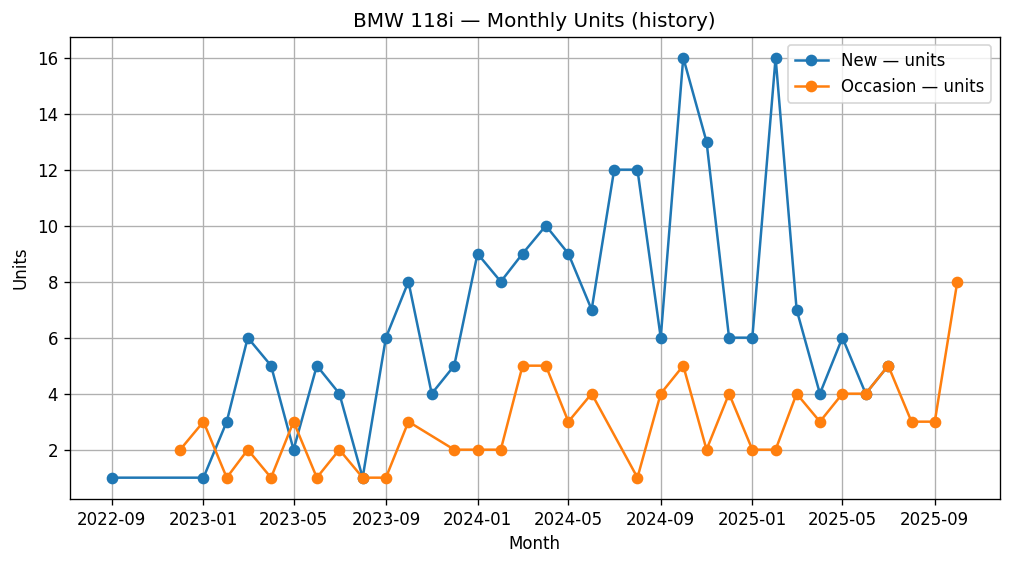

,month,Occasion,units,avg_price,market_cap
0,2022-09-01,0,1,38040.000000,38040.0
1,2022-12-01,1,2,50372.000000,100744.0
2,2023-01-01,0,1,45759.000000,45759.0
3,2023-01-01,1,3,49741.333333,149224.0
4,2023-02-01,0,3,43036.333333,129109.0


In [16]:
monthly = aggregate_monthly(df)

fig, ax = plt.subplots()
for occ, label in [(0, "New"), (1, "Occasion")]:
    sub = monthly[monthly["Occasion"]==occ]
    if not sub.empty:
        ax.plot(sub["month"], sub["units"], marker="o", label=f"{label} — units")
ax.set_title(f"{merk} {handelsbenaming} — Monthly Units (history)")
ax.set_xlabel("Month"); ax.set_ylabel("Units"); ax.legend()
plt.show()

monthly.head()

### Daily Dataset
We derive **daily unit counts** for each Occasion (new vs used).  
This is the base for day-level forecasting and for the **7-day drill-down** view in the dashboard.


In [27]:
daily = aggregate_daily(df)
print(f"Daily rows: {len(daily):,}")
daily.head()

Daily rows: 286


,date,Occasion,units
0,2022-09-29,0,1
1,2022-12-17,1,1
2,2022-12-22,1,1
3,2023-01-04,1,1
4,2023-01-06,1,1


### Holt–Winters Forecasting per Occasion
For each car type (new vs occasion), we:
1. Backtest the Holt–Winters model on recent months,
2. Train on the full history,
3. Forecast future sales and visualize results with confidence intervals.

[New] Backtest SMAPE (last 3 mo): 0.209


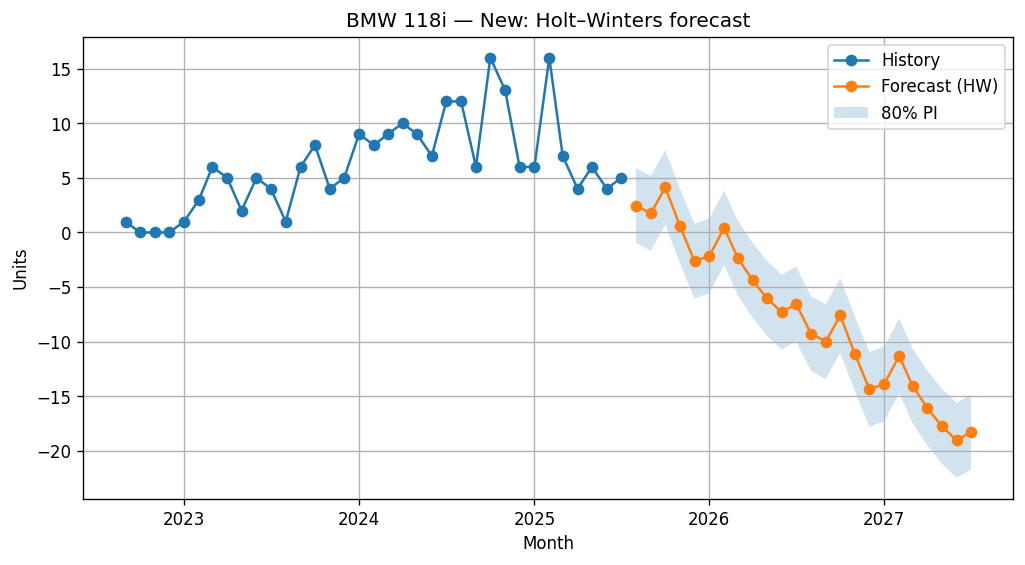

[Occasion] Backtest SMAPE (last 3 mo): 0.293


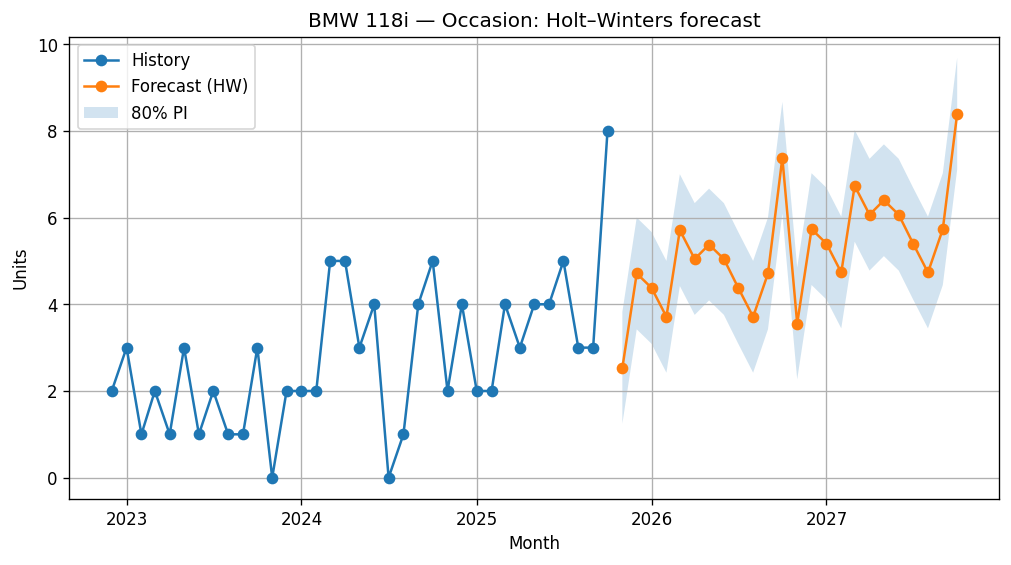

In [17]:
for occ, label in [(0, "New"), (1, "Occasion")]:
    sub = monthly[monthly["Occasion"]==occ].copy()
    if sub.empty:
        print(f"[{label}] No data, skipping.")
        continue

    ts = sub.set_index("month")["units"].asfreq("MS").fillna(0)

    # Backtest (hold last K months)
    holdout = min(3, max(1, len(ts)//6))
    train = ts.iloc[:-holdout]
    test  = ts.iloc[-holdout:]

    bt_fc = holt_winters_forecast(train, steps=holdout, seasonal="add")
    bt_fc = bt_fc.set_index("ds").reindex(test.index)
    bt_score = smape(test.values, bt_fc["yhat"].values)
    print(f"[{label}] Backtest SMAPE (last {holdout} mo): {bt_score:.3f}")

    # Fit on full history; forecast next 'monthly_horizon' months
    fc = holt_winters_forecast(ts, steps=monthly_horizon, seasonal="add")

    # Plot
    fig, ax = plt.subplots()
    ax.plot(ts.index, ts.values, marker="o", label="History")
    if fc["yhat"].notna().any():
        ax.plot(fc["ds"], fc["yhat"], marker="o", label="Forecast (HW)")
        ax.fill_between(fc["ds"], fc["lo80"], fc["hi80"], alpha=0.2, label="80% PI")
    ax.set_title(f"{merk} {handelsbenaming} — {label}: Holt–Winters forecast")
    ax.set_xlabel("Month"); ax.set_ylabel("Units"); ax.legend()
    plt.show()

### Interpretation of Holt–Winters Forecast Results

The two plots display the **Holt–Winters exponential smoothing forecasts** for monthly registration units of the **BMW 118i**, separated into _New_ and _Occasion (used)_ vehicles.  
The shaded region represents the **80% prediction interval (PI)**, while the orange line shows the model’s forecasted trend beyond the most recent observation.

#### New Vehicles
- The **historical trend** (blue line) indicates a gradual increase in monthly registrations throughout 2023–2024, followed by a plateau and slight decline toward 2025.  
- The **forecasted period** (orange) shows a continued **downward trajectory**, suggesting a potential contraction in new BMW 118i registrations over the next two years.  
- The **prediction interval widens** toward the end of the horizon, reflecting greater uncertainty as the forecast extends further.
- The **backtest SMAPE of 0.209** indicates **strong predictive accuracy** — the model’s short-term forecasts deviate by roughly 21% from the actual observed values, which is acceptable for time-series data of this granularity.

#### Occasion (Used) Vehicles
- The **historical pattern** displays irregular but moderate fluctuations, with periodic spikes possibly linked to secondary market cycles or data sparsity.  
- The **forecast** suggests a **steady increase** in used BMW 118i registrations, implying higher resale or turnover activity in the upcoming period.
- The **wider confidence band** reflects stronger volatility and less stable historical seasonality compared to new cars.
- The **backtest SMAPE of 0.293** shows **moderate accuracy** (around 29% deviation), acceptable given the smaller sample size and higher noise in the occasion segment.

#### Summary
Overall, the Holt–Winters model captures distinct dynamics for each market:
- **New vehicles**: declining trend and more predictable behavior.  
- **Occasions**: increasing trend but more uncertainty.  

These results suggest a **shift in demand** toward the second-hand BMW 118i market, potentially due to pricing, availability, or consumer preference trends.


### Daily Holt–Winters: Backtest and Forecast (Weekly Seasonality)
For each Occasion:
1) **Backtest** on the last `daily_backtest_days` using SMAPE,  
2) **Fit** Holt–Winters on the full daily history with **weekly seasonality (m=7)**,  
3) **Forecast** the next `daily_horizon_days` and visualize both **daily** and **7-day aggregated** views for the dashboard drill-down.

[New] Daily backtest SMAPE (last 14 d): 1.893


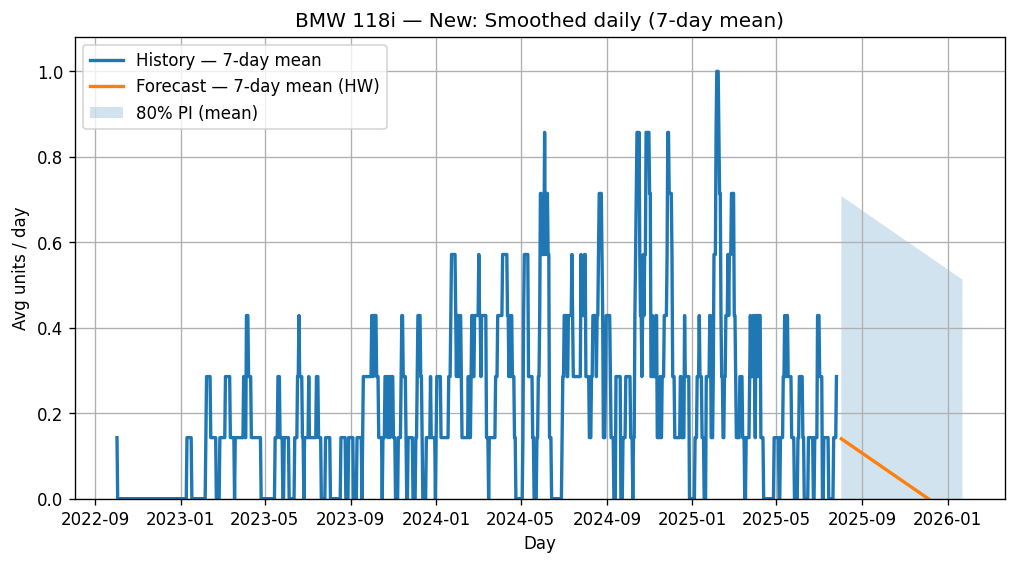

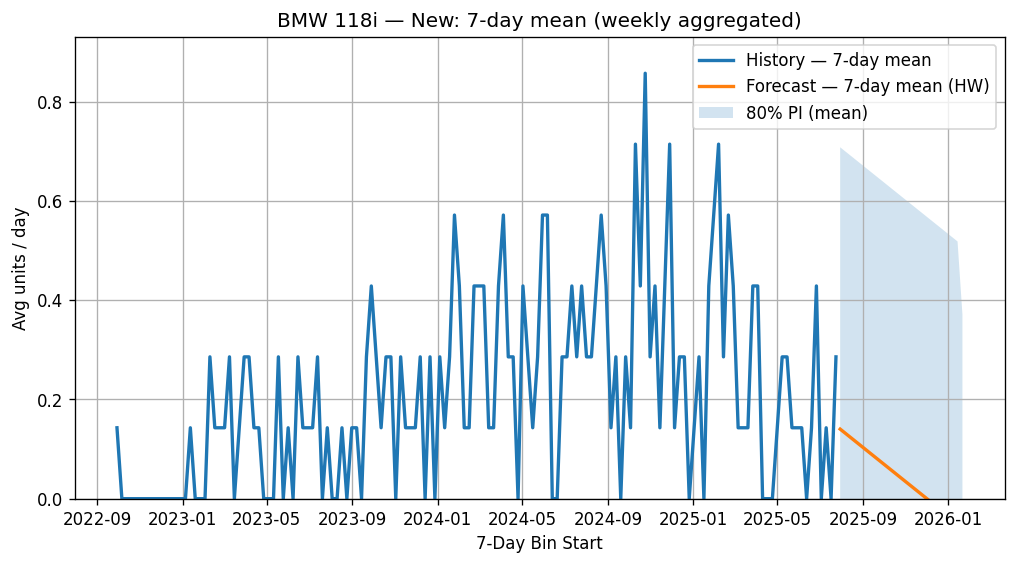

[Occasion] Daily backtest SMAPE (last 14 d): 1.940


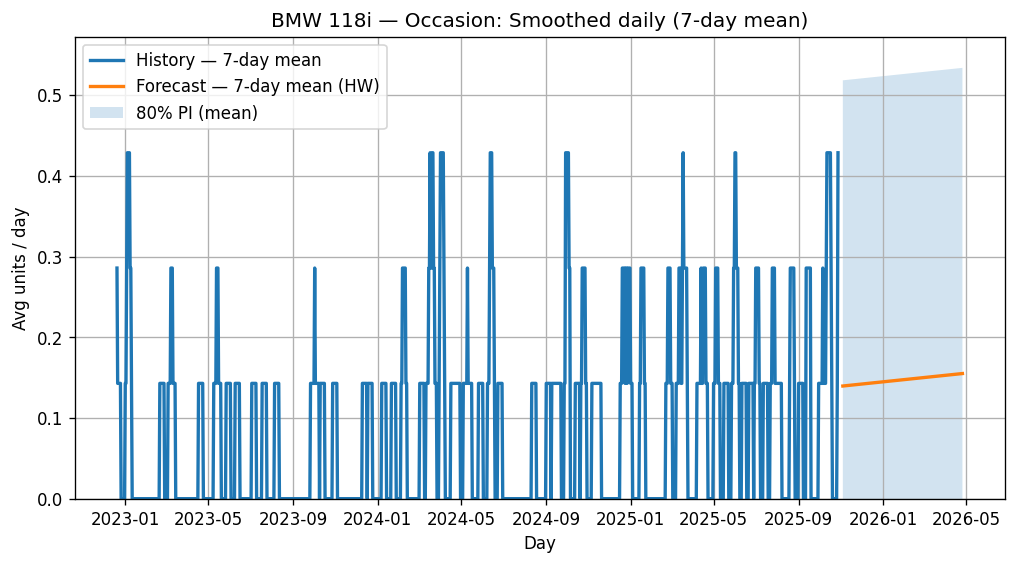

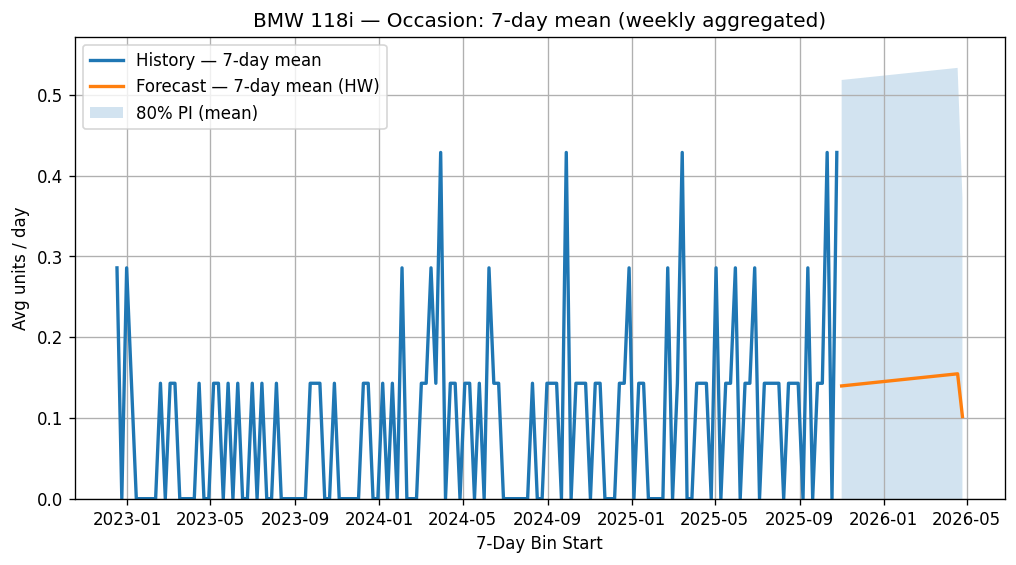

In [31]:
for occ, label in [(0, "New"), (1, "Occasion")]:
    sub = daily[daily["Occasion"] == occ].copy()
    if sub.empty:
        print(f"[{label}] No daily data, skipping.")
        continue

    ts = sub.set_index("date")["units"].asfreq("D").fillna(0)

    # ----- Backtest (last N days) -----
    holdout = min(daily_backtest_days, max(1, len(ts)//6))
    train = ts.iloc[:-holdout] if holdout > 0 else ts
    test  = ts.iloc[-holdout:] if holdout > 0 else pd.Series(dtype=float)

    bt_fc = holt_winters_forecast_daily(train, steps=len(test), season_periods=7)
    if len(test) > 0 and bt_fc["yhat"].notna().any():
        bt_fc = bt_fc.set_index("ds").reindex(test.index)
        bt_score = smape(test.values, bt_fc["yhat"].values)
        print(f"[{label}] Daily backtest SMAPE (last {len(test)} d): {bt_score:.3f}")
    else:
        print(f"[{label}] Daily backtest not computed (insufficient data).")

    # ----- Forecast on full daily history -----
    fc = holt_winters_forecast_daily(ts, steps=daily_horizon_days, season_periods=7)

    # ===== Plot A: Smoothed daily (7-day rolling mean, all lines) =====
    fig, ax = plt.subplots()

    # history mean
    hist_mean = ts.rolling(7, center=True).mean()
    ax.plot(hist_mean.index, hist_mean.values, linewidth=2, label="History — 7-day mean")

    # forecast mean + PI (smoothed)
    if fc["yhat"].notna().any():
        fc_mean = pd.Series(fc["yhat"]).rolling(7, center=True).mean()
        lo_mean = pd.Series(fc["lo80"]).rolling(7, center=True).mean()
        hi_mean = pd.Series(fc["hi80"]).rolling(7, center=True).mean()

        ax.plot(fc["ds"], fc_mean, linewidth=2, label="Forecast — 7-day mean (HW)")
        ax.fill_between(fc["ds"], lo_mean, hi_mean, alpha=0.2, label="80% PI (mean)")

    ax.set_title(f"{merk} {handelsbenaming} — {label}: Smoothed daily (7-day mean)")
    ax.set_xlabel("Day"); ax.set_ylabel("Avg units / day"); ax.legend()
    ax.set_ylim(bottom=0)
    plt.show()

    # ===== Plot B: 7-day mean via weekly aggregation (lines only) =====
    # history: aggregate to 7D sums and convert to mean
    hist_7d_sum  = ts.resample("7D").sum()
    hist_7d_mean = (hist_7d_sum / 7.0).rename("mean")

    # forecast: aggregate yhat/lo/hi to 7D, then divide by 7
    if fc["yhat"].notna().any():
        fc_tmp = fc.copy()
        fc_tmp_y  = fc_tmp[["ds", "yhat"]].rename(columns={"yhat":"y"})
        fc_tmp_lo = fc_tmp[["ds", "lo80"]].rename(columns={"lo80":"y"})
        fc_tmp_hi = fc_tmp[["ds", "hi80"]].rename(columns={"hi80":"y"})

        fc_7d   = aggregate_to_7day(fc_tmp_y,  col_name="y").rename(columns={"y":"yhat"})
        lo_7d   = aggregate_to_7day(fc_tmp_lo, col_name="y").rename(columns={"y":"lo80"})
        hi_7d   = aggregate_to_7day(fc_tmp_hi, col_name="y").rename(columns={"y":"hi80"})
        fc_7d   = fc_7d.merge(lo_7d, on="ds").merge(hi_7d, on="ds")

        # convert sums -> means
        fc_7d["yhat"] /= 7.0
        fc_7d["lo80"] /= 7.0
        fc_7d["hi80"] /= 7.0
    else:
        fc_7d = pd.DataFrame(columns=["ds","yhat","lo80","hi80"])

    fig, ax = plt.subplots()
    ax.plot(hist_7d_mean.index, hist_7d_mean.values, linewidth=2, label="History — 7-day mean")
    if not fc_7d.empty and fc_7d["yhat"].notna().any():
        ax.plot(fc_7d["ds"], fc_7d["yhat"], linewidth=2, label="Forecast — 7-day mean (HW)")
        ax.fill_between(fc_7d["ds"], fc_7d["lo80"], fc_7d["hi80"], alpha=0.2, label="80% PI (mean)")

    ax.set_title(f"{merk} {handelsbenaming} — {label}: 7-day mean (weekly aggregated)")
    ax.set_xlabel("7-Day Bin Start"); ax.set_ylabel("Avg units / day"); ax.legend()
    ax.set_ylim(bottom=0)
    plt.show()

### SARIMAX Forecast (Optional)
If an external CSV with an explanatory variable is provided, we perform a SARIMAX-based forecast for each occasion type.
Otherwise, the section is skipped.

In [18]:
if exog_csv_path:
    exog_df_raw = pd.read_csv(exog_csv_path)
    ex_series = prepare_exog_monthly(exog_df_raw, date_col=exog_date_col, value_col=exog_value_col)

    for occ, label in [(0, "New"), (1, "Occasion")]:
        sub = monthly[monthly["Occasion"]==occ].copy()
        if sub.empty:
            print(f"[{label}] No data, skipping SARIMAX.")
            continue

        ts = sub.set_index("month")["units"].asfreq("MS").fillna(0)
        fc = sarimax_with_exog(ts, ex_series, steps=monthly_horizon)

        fig, ax = plt.subplots()
        ax.plot(ts.index, ts.values, marker="o", label="History")
        if fc["yhat"].notna().any():
            ax.plot(fc["ds"], fc["yhat"], marker="o", label="Forecast (SARIMAX+exog)")
            ax.fill_between(fc["ds"], fc["lo80"], fc["hi80"], alpha=0.2, label="80% PI")
        ax.set_title(f"{merk} {handelsbenaming} — {label}: SARIMAX + exog forecast")
        ax.set_xlabel("Month"); ax.set_ylabel("Units"); ax.legend()
        plt.show()
else:
    print("No external regressor provided; skipping SARIMAX section.")

No external regressor provided; skipping SARIMAX section.


### Annual Market Cap Forecast
This section performs a yearly-level **Linear Regression forecast with bootstrapping**, evaluating the **market capitalization** (units × avg price).
Backtesting and uncertainty intervals are included to assess model stability.


[New] Annual backtest SMAPE (predict last year): 1.124


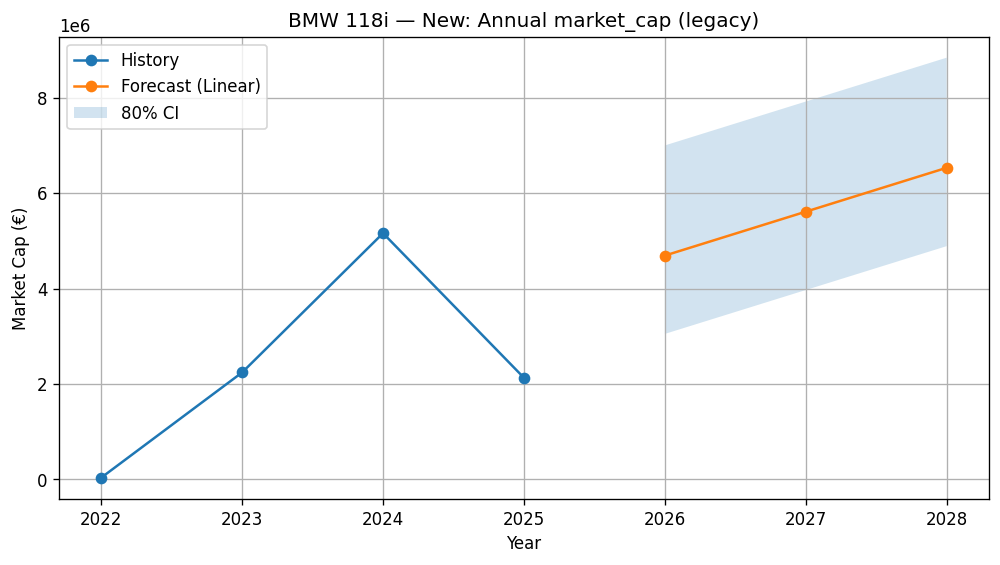

[Occasion] Annual backtest SMAPE (predict last year): 0.321


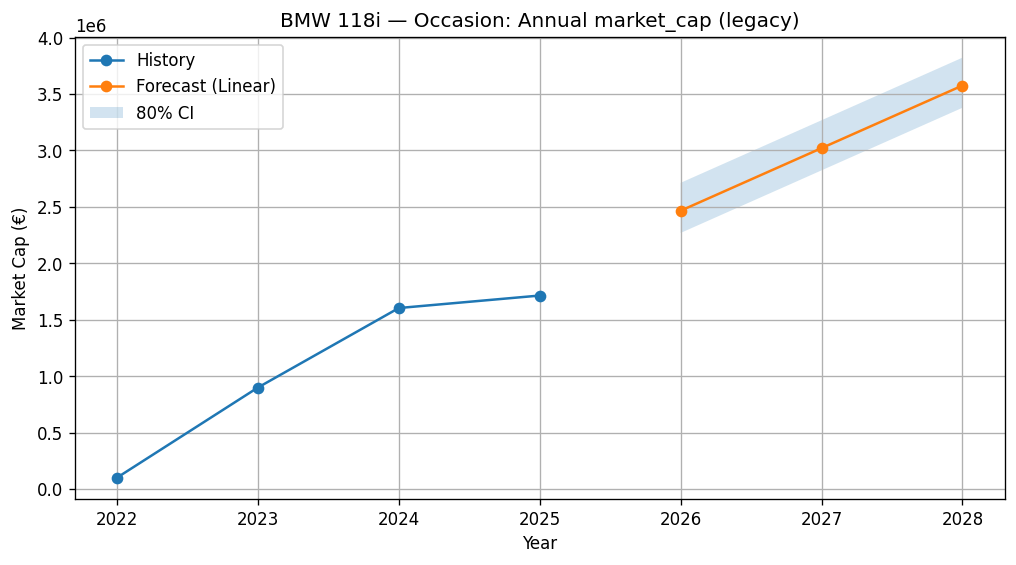

In [19]:
annual = aggregate_annual(df)

for occ, label in [(0, "New"), (1, "Occasion")]:
    sub = annual[annual["Occasion"]==occ].copy()
    if sub.shape[0] < 2:
        print(f"[{label}] Not enough annual points, skipping.")
        continue

    last_year = int(sub["year"].max())
    future_years = np.arange(last_year + 1, last_year + 1 + annual_horizon_years)

    fc = linear_forecast_with_bootstrap(sub, x_col="year", y_col="market_cap",
                                        future_x=future_years, n_boot=500)

    bt_score, bt = backtest_linear_one_step(sub, "year", "market_cap", holdout_last=1)
    if not math.isnan(bt_score):
        print(f"[{label}] Annual backtest SMAPE (predict last year): {bt_score:.3f}")

    # Plot
    fig, ax = plt.subplots()
    ax.plot(sub["year"], sub["market_cap"], marker="o", label="History")
    if not fc.empty and fc["yhat"].notna().any():
        ax.plot(fc["year"], fc["yhat"], marker="o", label="Forecast (Linear)")
        ax.fill_between(fc["year"], fc["lo80"], fc["hi80"], alpha=0.2, label="80% CI")
    ax.set_title(f"{merk} {handelsbenaming} — {label}: Annual market_cap (legacy)")
    ax.set_xlabel("Year"); ax.set_ylabel("Market Cap (€)"); ax.legend()
    plt.show()

###Dashboard Drill-down Payload (Year ➜ Month ➜ Day ➜ 3-Day)
We assemble a compact structure to support the dashboard’s hierarchical drill-down.  
You can export this structure to JSON in your app layer

In [29]:

drilldown_payload = {"New": {}, "Occasion": {}}

for occ, label in [(0, "New"), (1, "Occasion")]:
    annual_sub  = annual[annual["Occasion"]==occ][["year","units","avg_price","market_cap"]].copy()
    monthly_sub = monthly[monthly["Occasion"]==occ][["month","units","avg_price","market_cap"]].copy()
    daily_sub   = daily[daily["Occasion"]==occ][["date","units"]].copy()

    drilldown_payload[label]["annual"]  = annual_sub
    drilldown_payload[label]["monthly"] = monthly_sub
    drilldown_payload[label]["daily"]   = daily_sub

print("Drill-down payload assembled (DataFrames).")

Drill-down payload assembled (DataFrames).
